# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../../.."))

In [2]:
import optuna
import pandas
import torch
import numpy

from tqdm import tqdm
from math import comb, sqrt, isnan
from itertools import combinations, product
from typing import Callable
from scipy.stats import gaussian_kde
from belashovplot import TiledPlot, FontLibraryClass

from parameters import FigureWidthHeight, FontLibrary
from utilities.methods import upper_integer

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 14

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8

FontLibrary.Fonts.GraphTitle.FontSize = 10

FigureWidthHeight = (7, 100)

In [4]:
device = torch.device(1)

# Выгружаем данные

In [15]:
study = optuna.create_study(study_name="Default", storage="sqlite:///DNL.db", direction='maximize', load_if_exists=True)
dataframe = study.trials_dataframe()
dataframe = dataframe[dataframe['params_learning_rate'] <= 2.0]
dataframe = dataframe[dataframe['value'] > 80.0]
columns = [key for key in dataframe.keys() if key.startswith('params_') and len(set(dataframe[key].tolist())) >= 2]
len(dataframe)

[I 2024-10-04 10:50:41,903] Using an existing study with name 'Default' instead of creating a new one.


90

# Точность в зависимости от различных гиперпараметров

In [16]:
values = dataframe['value'].tolist()
parameters = []
delete_idx = []
for i, value in enumerate(values):
    if (value is None or isnan(value)) and i not in delete_idx: delete_idx.append(i)
for column in columns:
    dtype = dataframe[column].dtype
    if dtype == 'object':
        parameters.append(dataframe[column].tolist())
        for i, parameter in enumerate(parameters[-1]):
            if parameter == 'NaN' and i not in delete_idx: delete_idx.append(i)
    elif dtype in ['int64', 'float64']:
        parameters.append([float(value) for value in dataframe[column].tolist()])
        for i, parameter in enumerate(parameters[-1]):
            if (parameter is None or isnan(parameter)) and i not in delete_idx: delete_idx.append(i)
    else: print(f"Unknown type {dtype} of column {column}")
delete_idx.sort()
for i in reversed(delete_idx):
    values.pop(i)
    for j in range(len(parameters)):
        parameters[j].pop(i)
values_array = numpy.array(values)

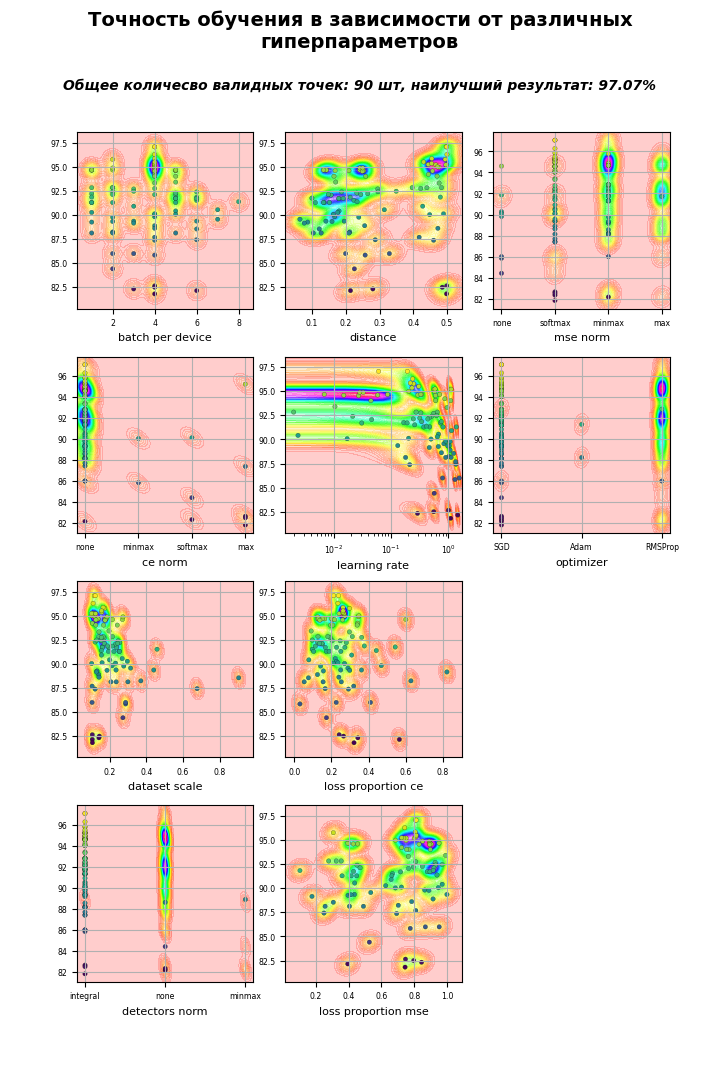

In [17]:
total = len(columns)
cols = int(sqrt(total))
if cols <= 0: cols = 1
rows = upper_integer(total/cols)

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.pad.graph.vertical(0.05)
plot.pad.graph.horizontal(0.05)
plot.title("Точность обучения в зависимости от различных гиперпараметров")
plot.description.top(f"Общее количесво валидных точек: {len(values)} шт, наилучший результат: {round(max(values),2)}%")

for (col, row), parameter, column in zip(product(range(cols),range(rows)), parameters, columns):
    axes = plot.axes.add(col, row)
    
    array = numpy.array(parameter)
    if isinstance(parameter[0], str):
        variants = list(set(parameter))
        variants = {variant:i for i, variant in enumerate(variants)}
        array = numpy.array([variants[value] for value in parameter])
        axes.xaxis.set_ticks(range(len(variants)))
        axes.xaxis.set_ticklabels(variants)
    stacked = numpy.vstack([array, values_array])
    kde = gaussian_kde(stacked, bw_method=0.15)
    density = kde(stacked)
    x_min, x_max = array.min(), array.max()
    y_min, y_max = values_array.min(), values_array.max()
    x_len, y_len = x_max - x_min, y_max - y_min
    alpha = 0.1
    x_min, x_max, y_min, y_max = x_min-alpha*x_len, x_max+alpha*x_len, y_min-alpha*y_len, y_max+alpha*y_len
    x_mesh, y_mesh = numpy.meshgrid(numpy.linspace(x_min, x_max, 100), numpy.linspace(y_min, y_max, 100))
    positions = numpy.vstack([x_mesh.ravel(), y_mesh.ravel()])
    z_mesh = numpy.reshape(kde(positions), x_mesh.shape)*y_mesh
    # print(positions)
    axes.contourf(x_mesh, y_mesh, z_mesh, cmap='hsv', alpha = 0.2, levels=128)
    # axes.imshow(numpy.rot90(z_mesh), extent=[x_min,x_max,y_min,y_max], aspect='auto', cmap='hsv', alpha=0.5)

    axes.scatter(parameter, values, c=values, edgecolors='black', linewidths=0.15, s=10)
    axes.grid(True)
    plot.graph.label.x(column[7:].replace('_', ' '))

    # axes.set_yscale('log')
    if 'learning_rate' in column:
        axes.set_xscale('log')

plot.save(f"DNL_VFPD_{len(values)}.png")

# Выделение обособленных прямоугольников высокой точности в пространстве гиперпараметров

In [18]:
# Выбираем и нормируем данные
redirector = {}
data = []
to_remove_ids = []
for column in ['value'] + columns:
    if dataframe[column].dtype == 'object':
        if column not in redirector.keys():
            variants = list(set(dataframe[column].tolist()) - set('none'))
            values = [i/(len(variants)-1) for i in range(len(variants))]
            redirector[column] = {variant:value for variant, value in zip(variants, values)}
        column_data = [redirector[column][value] for value in dataframe[column].tolist()]
    elif dataframe[column].dtype == 'int64' or dataframe[column].dtype == 'float64':
        column_data = [float(value) for value in dataframe[column].tolist()]
    else: print(f"Unknown type: {dataframe[column].dtype}")
    data.append(column_data)
data = torch.tensor(data).swapdims(0,1)

none_triggers = torch.sum(torch.isnan(data), dim=1)
indexes = torch.where(none_triggers)[0].flip(dims=(0,))
for index in indexes:
    data = torch.concatenate([data[:index], data[index+1:]])
    
data_mean = torch.mean(data, dim=0)
data_std = torch.std(data, dim=0)
data_std = torch.where(data_std == 0, 1.0, data_std)  
data = (data - data_mean) / data_std

values = data[:,0]*data_std[0] + data_mean[0]

data = data[:,1:]
data_std = data_std[1:]
data_mean = data_mean[1:]

In [19]:
def unify_points(point:torch.Tensor, points:torch.Tensor, values:torch.Tensor):
    if point.shape[-1] != points.shape[-1]: raise Exception(f"Different dimension data: {point.shape} and {points.shape}")
    point_shape = point.shape
    if len(point.shape) == 1: 
        point = point.unsqueeze(0)
    elif len(point.shape) > 2:
        point = point.view(-1, point_shape[-1])
    points_shape = points.shape
    if len(points.shape) > 2:
        points = points.view(-1, points_shape[-1])
    values_shape = values.shape
    if len(values.shape) > 1:
        values = values.view(-1)
    refs = points.shape[0]
    srcs = point.shape[0]
    dims = point.shape[1]
    return point, points, values, point_shape, points_shape, values_shape, refs, srcs, dims

def sort_points(point:torch.Tensor, points:torch.Tensor, values:torch.Tensor):
    point, points, values, point_shape, points_shape, values_shape, refs, srcs, dims = unify_points(point, points, values)
    difference = torch.square(point.expand(refs, srcs, dims).swapdims(0,1) - points.expand(srcs, refs, dims))
    difference = torch.sqrt(torch.sum(difference, dim=2))
    difference, indexes = torch.sort(difference, dim=1)

    sorted_points = points[indexes].reshape(*point_shape[:-1], *points_shape[:-1], dims)
    sorted_values = values[indexes].reshape(*point_shape[:-1], *values_shape)
    return sorted_points, sorted_values

def nonsingular(rows:torch.Tensor):
    rows_shape = rows.shape
    if len(rows.shape) == 2:
        rows = rows.unsqueeze(0)
    if len(rows.shape) > 2:
        rows = rows.view(-1, *rows.shape[-2:])
    dims = rows.shape[-1]
    matrixes = []
    for data in rows:
        cursor = 1
        matrix = data[1:2, :].expand(dims, dims)
        for rank in range(1, dims):
            while torch.linalg.matrix_rank(matrix) <= rank:
                matrix = torch.concatenate([matrix[:rank], data[cursor:cursor+dims-rank]])
                cursor += 1
            print(torch.linalg.matrix_rank(matrix))
        print(torch.linalg.matrix_rank(matrix), dims)

sorted_data, sorted_values = sort_points(torch.rand(4, data.shape[-1]), data, values)
print(torch.linalg.matrix_rank(sorted_data[0].swapdims(0,1)))
print(sorted_data.shape, sorted_values.shape)
# matrixes = nonsingular(sorted_data)

tensor(10)
torch.Size([4, 90, 10]) torch.Size([4, 90])


In [20]:
alpha = 0.05
N = 250
limits = []
spaces = []
for column in data.swapdims(0,1):
    limit = [column.min().item(), column.max().item()]
    length = limit[1] - limit[0]
    shift = length*alpha
    limit = [limit[0]-shift, limit[1]+shift]
    limits.append(limit)
    space = torch.linspace(limit[0], limit[1], N)
    spaces.append(space)


# Выявление кластеров с помощью вращения

In [21]:
columns = [key for key in dataframe.keys() if key.startswith('params_') or key in ['value']]
redirector = {}
data = []
to_remove_ids = []
for column in columns:
    if dataframe[column].dtype == 'object':
        if column not in redirector.keys():
            variants = list(set(dataframe[column].tolist()) - set('none'))
            values = [i/(len(variants)-1) for i in range(len(variants))]
            redirector[column] = {variant:value for variant, value in zip(variants, values)}
        column_data = [redirector[column][value] for value in dataframe[column].tolist()]
    elif dataframe[column].dtype == 'int64' or dataframe[column].dtype == 'float64':
        column_data = [float(value) for value in dataframe[column].tolist()]
    else: print(f"Unknown type: {dataframe[column].dtype}")
    data.append(column_data)
data = torch.tensor(data).swapdims(0,1)

none_triggers = torch.sum(torch.isnan(data), dim=1)
indexes = torch.where(none_triggers)[0].flip(dims=(0,))
for index in indexes:
    data = torch.concatenate([data[:index], data[index+1:]])
data_mean = torch.mean(data, dim=0)
data_std = torch.std(data, dim=0)
data_std = torch.where(data_std == 0, 1.0, data_std)  
data = (data - data_mean) / data_std

In [22]:
def rotate(vector:torch.Tensor, angles:torch.Tensor):
    device = vector.device
    matrix = torch.eye(vector.shape[-1], device=device)
    sins = torch.sin(angles)
    coss = torch.cos(angles)
    for (i, j), sin, cos in zip(combinations(range(vector.shape[-1]), 2), sins, coss):
        matrix_ = torch.eye(vector.shape[-1], device=device)
        matrix_[i][i] = +cos
        matrix_[i][j] = -sin
        matrix_[j][i] = +sin
        matrix_[j][j] = +cos
        matrix = torch.matmul(matrix, matrix_)
    return torch.matmul(vector, matrix)

def optimize(data:torch.Tensor, function:Callable[[torch.Tensor],torch.Tensor]):
    angles = torch.nn.Parameter(torch.rand(comb(data.shape[1], 2), device=device))
    scales = torch.nn.Parameter(torch.rand(data.shape[1], device=device))
    shifts = torch.nn.Parameter(torch.rand(data.shape[1], device=device))
    cuda_data = data.to(device)
    history = []
    
    def loss():
        new_data = rotate(cuda_data, angles)[:,1:3]
        error = function(new_data, cuda_data[:,0])
        return error

    optimizer = torch.optim.Adam([angles, scales, shifts], lr=0.01)

    for i in tqdm(range(100)):
        error = loss()
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        history.append(error.item())

    # print(f"Angles: " + ", ".join([f"{round(180*angle.item()/3.1415,1)}" for angle in angles]))
    # print(f"Scales: " + ", ".join([f"{round(180*scale.item()/3.1415,1)}" for scale in scales]))
    # print(f"Shifts: " + ", ".join([f"{round(180*shift.item()/3.1415,1)}" for shift in shifts]))
    
    return rotate(cuda_data*scales + shifts, angles)[:,:2].clone().detach().cpu(), history

def error_function(points:torch.Tensor, values:torch.Tensor):
    count = points.shape[0]
    x_array = points[:,0]
    y_array = points[:,1]
    x_mesh_1, x_mesh_2 = torch.meshgrid(x_array, x_array, indexing='ij')
    y_mesh_1, y_mesh_2 = torch.meshgrid(y_array, y_array, indexing='ij')
    x_deltas = x_mesh_1 - x_mesh_2
    y_deltas = y_mesh_1 - y_mesh_2
    deltas = x_deltas**2 + y_deltas**2

    temp_mesh_1, temp_mesh_2 = torch.meshgrid(values, values, indexing='ij')
    temp_deltas = (temp_mesh_1 - temp_mesh_2)**2

    forces = temp_deltas**deltas
    potential = torch.sum(forces)
    
    return potential

In [23]:
old_data = data[:,1:3]
cols = 2
rows = 2
rotated_datas = []
for _ in range(cols*rows):
    new_data, history = optimize(data[:,1:], error_function)
    rotated_datas.append(new_data)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.81it/s]


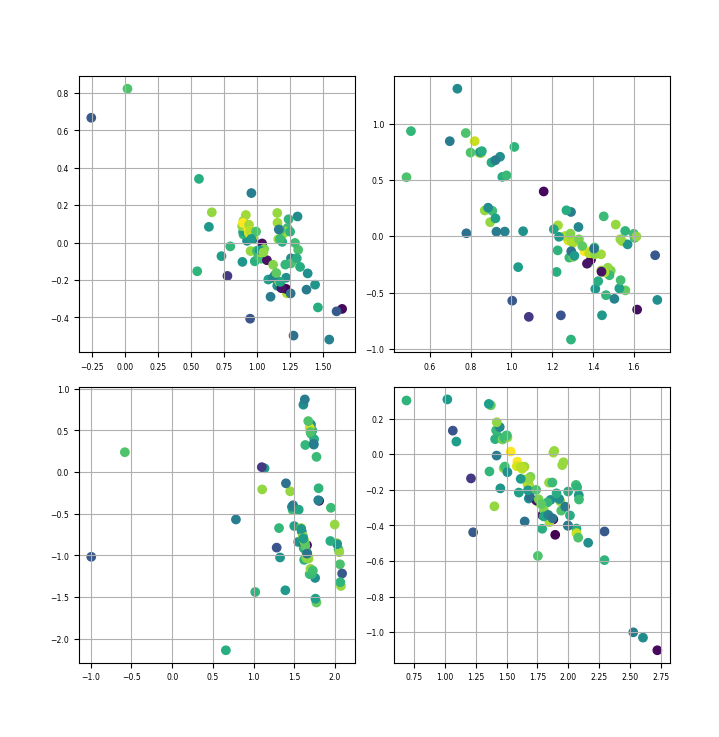

In [24]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

for (col, row), new_data in zip(product(range(cols),range(rows)), rotated_datas):
    axes = plot.axes.add(col,row)
    axes.scatter(new_data[:,0], new_data[:,1], c=data[:,0], cmap='viridis')
    axes.grid(True)

plot.show()